<a href="https://colab.research.google.com/github/Heiley-W/Gravitational-Wave-Open-Data-Workshop/blob/main/summary/GW2_Q-transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages

In [4]:
#!pip install gwpy
#!pip install gwosc

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import gwpy

In [5]:
# Load data for GW170817 event

from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
print("GW170817 GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)

GW170817 GPS: 1187008882.4


## 1. How frequency-domain content evolves over multiple time periods

Fast Fourier transform (FFT) and Amplitude Spectrum Density (ASD) allow us to know the frequency-domain content in a single time interval.

To show how the frequency-domain content evolves over time, we use spectrograms. It shows FFT or ASD at each time step on a time-frequency representation. It's best used to see general trends in how the sensitivity of the GW detectors is changing over longish periods (minutes or hours).

- `spectrogram()` shows an averaged ASD every time interval, best for longer time period to remove short noise burusts

- `spectrogram2()` shows single-FFT ASD at each time step. FFTs can include overlapping segments, best for shorter time period

Arguments:
-  `fftlength` : float
    number of seconds in single FFT

- `overlap` : float, optional
    number of seconds of overlap between FFTs, defaults to therecommended overlap for the given window

- `window` : str, numpy.ndarray, optional
    window function to apply to timeseries prior to FFT

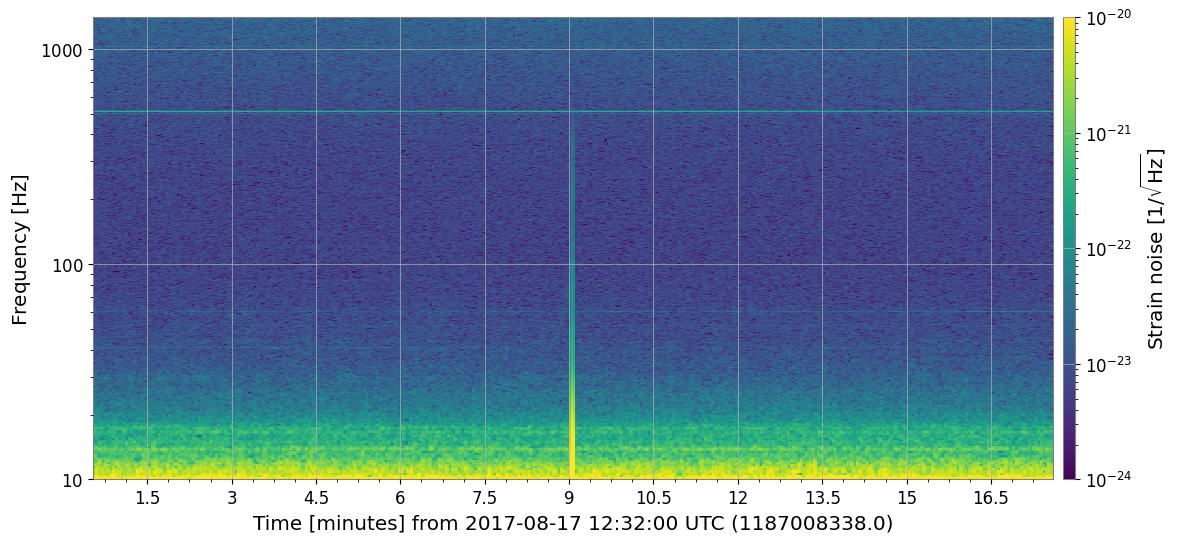

In [10]:
specgram = ldata.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)

# Plot spectrogram
plot = specgram.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400) # to match ASD intensity
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)

We can see that the low-frequency noise (<30 Hz) rumbles along with some variation, but high frequencies (>100 Hz) are relatively stable. Between 30-100 Hz we can see some narrow features appearing and disappearing as non-stationary noise affects the measurement.

## 2. Apply Q-transforms to understand energy at different frequencies

Problem with FFT:
- Impossible to pick a window duration appropriate for all frequencies
- Low frequency signal requires long-duration windows, vice versa

Solution:
- To search for a statistically significant excess of signal power in the time–frequency plane, we apply the Q-transform filter. It t produce a logarithmic tiling of the time–frequency plane, providing increasing time resolution at higher frequencies

- `hdata.q_transform(frange=(30, 500), qrange=(100, 110), outseg=(gps-3,gps+0.5))`

Arguments:
- `frange=(30, 500)` Frequency range
- `qrange=(100,110)` Quality factor range
- `outseg=(gps-3,gps+0.5)` Zoom in around the merger

In [17]:
# Load data with different segment and detector
segment = (int(gps) - 30, int(gps) + 2)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)

Fetched 1 URLs from gwosc.org for [1187008852 .. 1187008884))
Reading data... [Done]


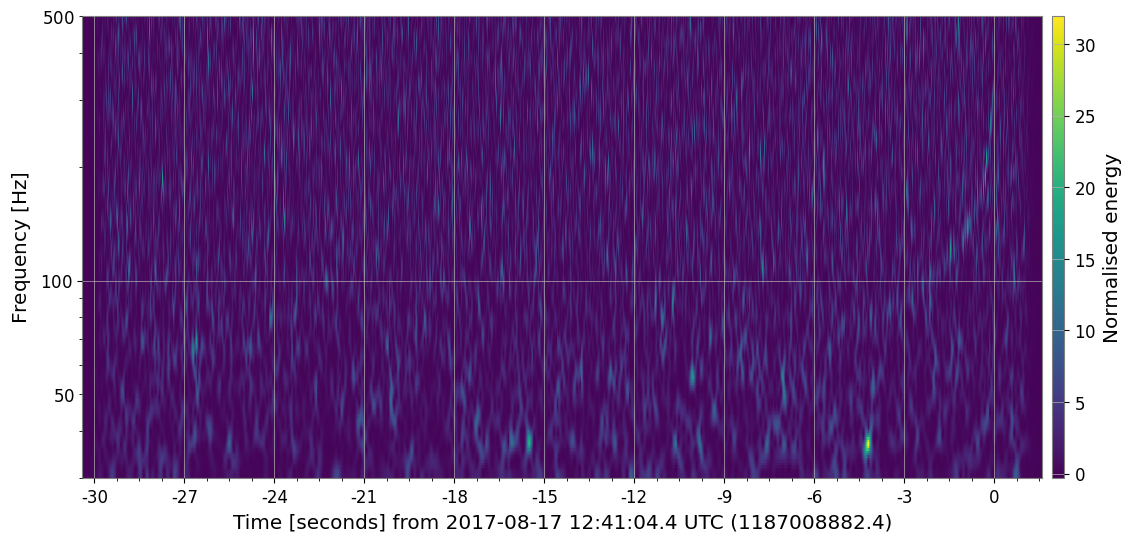

In [11]:
hq = hdata.q_transform(frange=(30, 500))

# Plot spectrogram
plot = hq.plot()
plot.colorbar(label="Normalised energy")
ax = plot.gca()
ax.set_epoch(gps)
ax.set_ylim(30, 500)
ax.set_yscale("log")

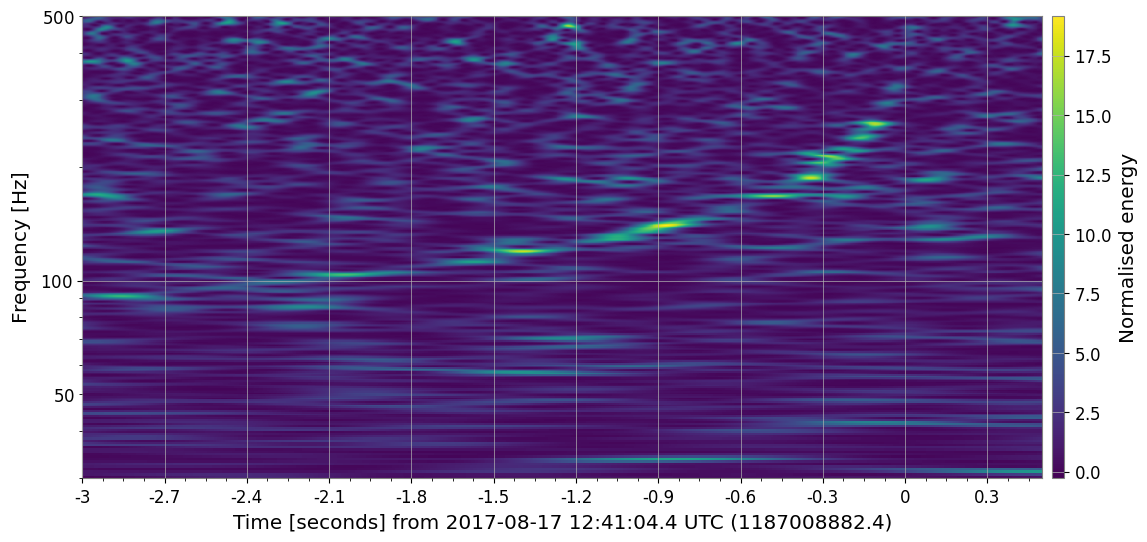

In [14]:
hq = hdata.q_transform(frange=(30, 500), qrange=(100, 110), outseg=(gps-3,gps+0.5)) # choose specific range
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

## 3. Remove large glitches

Problem: In the following example, an instrumental glitch almost exactly overlaps the BNS signal in LIGO-Livingston.

Solution: Gating
- Removes high amplitude peaks from data using inverse Planck window.Points will be discovered automatically using a provided threshold
and clustered within a provided time window.
- `ldata.gate(tzero=0.25, tpad=0.25)`


Arguments:
- `tzero=0.25` half-width time duration (seconds) in which the timeseries is set to zero

- `tpad=0.25` half-width time duration (seconds) in which the Planck window
is tapered

In [ ]:
# Example of instrumental glitch everllapping the BNS signal

lq = ldata.q_transform(frange=(30, 500), qrange=(100, 110), outseg=(gps-15,gps+0.5)) # choose specific range
plot = lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(0,20)

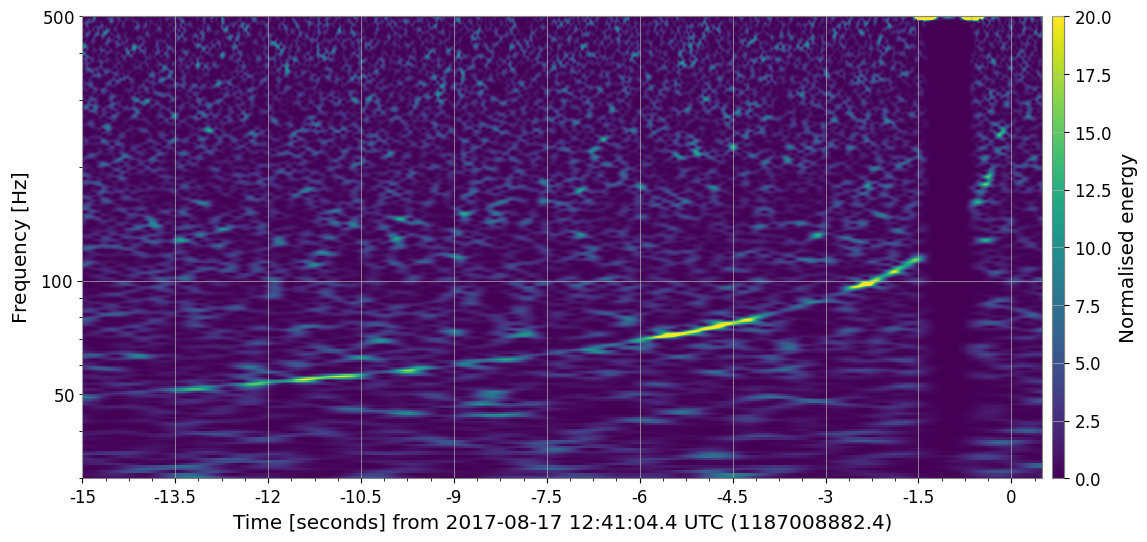

In [32]:
gated_ldata = ldata.gate(tzero=0.25, tpad=0.25)

# Plot filtered data
gated_lq = gated_ldata.q_transform(frange=(30, 500), qrange=(100, 110), outseg=(gps-15,gps+0.5)) # choose specific range
plot = gated_lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(0,20)